In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn import tree
from sklearn.inspection import permutation_importance

plt.rcParams.update({'figure.figsize':(12,6)})
plt.rcParams.update({'font.size':20})

In [2]:
test = pd.read_csv("test_table.csv")
user = pd.read_csv("user_table.csv")

In [3]:
test.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [4]:
user.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


In [5]:
len(test['user_id'].unique()) == test.shape[0]

True

In [6]:
len(user['user_id'].unique()) == user.shape[0]

True

In [7]:
test.shape[0] - user.shape[0]

454

User ids are unique for each record in both test and user tables. There are 454 users existing in the test table but missing in the user table. I would use left join to make sure these users are not lost.

In [8]:
df = test.merge(user, on = "user_id", how = "left")
df

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,M,32.0,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34.0,Spain
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico
...,...,...,...,...,...,...,...,...,...,...,...,...
453316,425010,2015-12-04,SEO,Web,ES,NaN,FireFox,0,0,M,50.0,Mexico
453317,826793,2015-12-01,SEO,Mobile,ES,NaN,Android_App,0,1,F,20.0,Colombia
453318,514870,2015-12-02,Ads,Mobile,ES,Bing,Android_App,0,0,M,25.0,Spain
453319,785224,2015-12-04,SEO,Mobile,ES,NaN,Android_App,0,1,M,21.0,Colombia


Text(0.5, 1.0, 'Conversion Rate by Country')

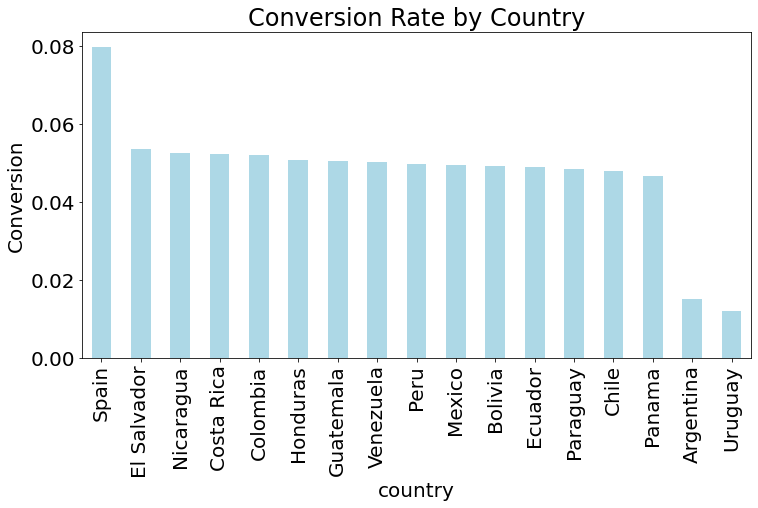

In [9]:
df[df.test == 0].groupby('country')['conversion'].mean().sort_values(ascending=False).plot(kind='bar',color='lightblue')
plt.ylabel('Conversion')
plt.title('Conversion Rate by Country')

Yes. Spain converts much better than other LatAm countries. Also, nothing changed in Spain, so we could delete these rows in further analysis.

In [10]:
df = df[df.country != "Spain"]
control_result = df[df.test == 0]['conversion']
test_result = df[df.test == 1]['conversion']
stats.ttest_ind(control_result,test_result)

Ttest_indResult(statistic=7.422512095954769, pvalue=1.15144687852198e-13)

In [11]:
n1 = len(control_result)       # number of observations in sample 1
n2 = len(test_result)    # number of observations in sample 2
p_bar1 = np.mean(control_result)    # proportion in sample 1
p_bar2 = np.mean(test_result) # proportion in sample 2

In [12]:
print('Conversion rate of control group is ' + str(round(p_bar1 * 100,2)) + '%.')
print('Conversion rate of test group is ' + str(round(p_bar2 * 100,2)) + '%.')

Conversion rate of control group is 4.83%.
Conversion rate of test group is 4.34%.


In [13]:
p_bar = (sum(test_result) + sum(control_result)) / (n1 + n2)             # overall proportion
std_error = np.sqrt(p_bar*(1-p_bar)*(1/n1+1/n2))  # standard error
test_statistic = (p_bar1 - p_bar2)/std_error      # test statistic

2*stats.norm.sf(abs(test_statistic))

1.1534615081524852e-13

From the t-test, p-value is smaller than 0.05, which means that we could reject the null hypothesis that conversion rate of control group and test group is same. We can conclude that the differnece is significant and test is negative. That is, the old version of the site with just one translation across Spain and LatAm performs better.


The most likely reason for weird A/B test results are:
- We didn’t collect enough data.
- Some bias has been introduced in the experiment so that test/control people are not really
random.


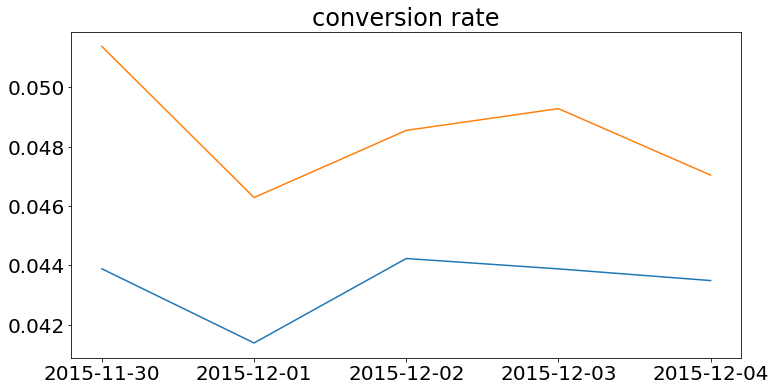

In [14]:
a = df[df.test == 1].groupby("date")["conversion"].mean()
b = df[df.test == 0].groupby("date")["conversion"].mean()
plt.title("conversion rate")
plt.plot(a)
plt.plot(b)
plt.show()

we just ran it for 5 days. We should always run the test for at least 1 full week to capture weekly patterns, 2 weeks would be much better.

Then, we run a decision tree with 'test' as target variable to check whether users are randomly distributed in two groups.

In [15]:
X = df.drop(columns = ["conversion","test","user_id","date"])
y = df['test']
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401539 entries, 1 to 453320
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   source            401539 non-null  object 
 1   device            401539 non-null  object 
 2   browser_language  401539 non-null  object 
 3   ads_channel       160984 non-null  object 
 4   browser           401539 non-null  object 
 5   sex               401085 non-null  object 
 6   age               401085 non-null  float64
 7   country           401085 non-null  object 
dtypes: float64(1), object(7)
memory usage: 27.6+ MB


In [16]:
X['age'] = X['age'].fillna(X['age'].mean(),inplace=True)
X[['ads_channel','sex','country']] = X[['ads_channel','sex','country']].fillna('NA')
X = pd.get_dummies(X)

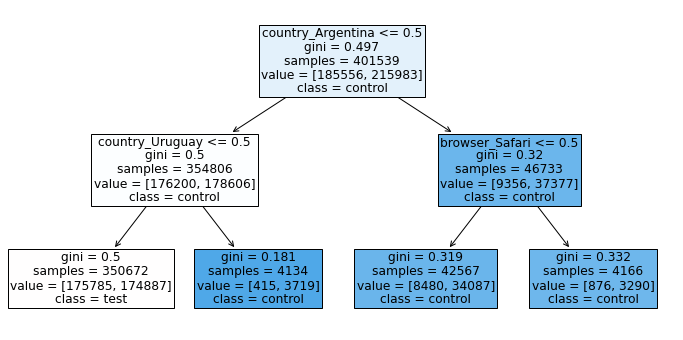

In [17]:
clf = tree.DecisionTreeClassifier(max_depth=2).fit(X, y)
fig = tree.plot_tree(clf, feature_names=X.columns, class_names=["test", "control"], filled=True)

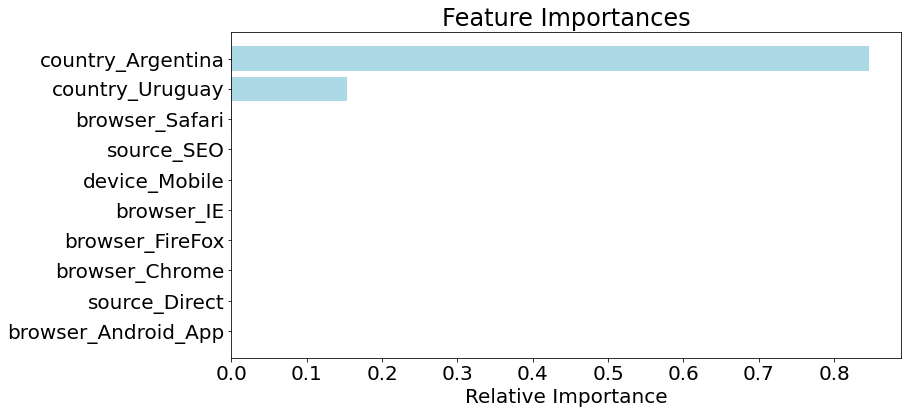

In [18]:
importances = clf.feature_importances_
indices = np.argsort(importances)
num_features = 10 
features = X.columns.tolist()
plt.title('Feature Importances')
plt.barh(range(num_features), importances[indices[-num_features:]], color = 'lightblue', align='center')
plt.yticks(range(num_features), [features[i] for i in indices[-num_features:]])
plt.xlabel('Relative Importance')
plt.show()

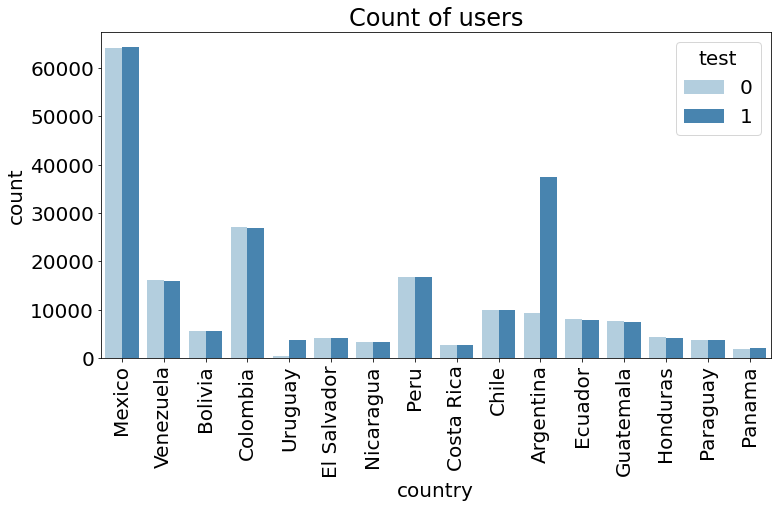

In [19]:
sns.countplot(data=df,x='country',hue="test",palette = "Blues")
plt.title("Count of users")
plt.xticks(rotation=90)
plt.show()

If the randomization worked, the tree should not split at all (or at least not be able to separate the two classes well). However, from the result of decision tree and the count plot, we can see that Argentina and Uruguay is much more likely to end up in the test set. This segment had a significantly below conversion rate and affected the overall results.

In [20]:
df = df[~df.country.isin(["Spain","Argentina","Uruguay"])]
a= df[df.test == 1]['conversion']
b= df[df.test == 0]['conversion']
stats.ttest_ind(a,b)

Ttest_indResult(statistic=0.31810128971456436, pvalue=0.7504082947797941)

If we remove these two countries, the resulted difference is not significant any more.

In [21]:
def f(x):
    d = {}
    d['p_value'] = stats.ttest_ind(a= x[x.test == 1]['conversion'],b= x[x.test == 0]['conversion']).pvalue
    d['conversion_test'] = x[x.test == 1]['conversion'].mean()
    d['conversion_control'] = x[x.test == 0]['conversion'].mean()    
    return pd.Series(d, index = ['p_value','conversion_test','conversion_control'])

In [22]:
df_p = df.groupby("country").apply(f).sort_values('p_value')
df_p

,p_value,conversion_test,conversion_control
country,,,
Mexico,0.165547,0.051186,0.049495
El Salvador,0.248251,0.047947,0.053554
Chile,0.302871,0.051295,0.048107
Colombia,0.423733,0.050571,0.052089
Honduras,0.471721,0.047540,0.050906
Guatemala,0.572165,0.048647,0.050643
Venezuela,0.573740,0.048978,0.050344
Costa Rica,0.687863,0.054738,0.052256
Panama,0.705361,0.049370,0.046796


After we control for country, the test clearly appears non significant. Not a great success given that the goal was to improve conversion rate, but at least we know that a localized translation didn’t make things worse!